# Setups

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import display

In [2]:
from ukbb_parser import create_dataset, create_ICD10_dataset, get_chrom_raw_marker_data, get_chrom_imputation_data
from ukbb_parser.shared_utils.util import summarize

In [3]:
# XXX: DELTE THIS CELL (and DO NOT execute it)!

# We override the 'summarize' function so that this notebook could be published online, together with its output, without
# compormising the privacy of the UKBB's participants. When this version is used, all displayed dataframes and series
# values will be shuffled (column-wise) using a cryptographically secure random generator.
# When using this notebook as part of your real research, you clearly do not want this shuffling (which would completely
# obscure the true values in your analysis). Therefore you should delete this cell altogether (and no need to bother
# yourself with this code).
def summarize(df, n = 5):
    
    import secrets
    
    if isinstance(df, pd.DataFrame) and df.columns.tolist() == ['coding', 'meaning', 'parent_id', 'selectable', \
            'children_ids', 'samples', 'n_samples']:
        
        # When summarizing ICD10_tree (see below), it is sufficient to replace the samples with random numbers.
        displayed_head = df.head(n).copy()
        displayed_head['samples'] = displayed_head['n_samples'].apply(lambda n_samples: set(np.random.randint(0, \
                200000, n_samples)))
        display(displayed_head)
        print('Displaying %d of %d records (replaced the samples with random indices).' % (n, len(df)))
        return
    
    if isinstance(df, pd.DataFrame) and df.columns.tolist() == ['fid', 'iid', 'father', 'mother', 'gender', 'trait', 'i']:
        # When displaying a fam dataframe, we do not want to shuffle the 'i' values.
        cols_to_exclude_from_shuffling = {'i'}
    else:
        cols_to_exclude_from_shuffling = set()
    
    def _sample_series(original_series):
        return pd.Series([secrets.choice(original_series.values) for _ in range(n)]).rename(original_series.name)
    
    if isinstance(df, pd.Series):
        displayed_head = _sample_series(df)
    elif isinstance(df, pd.DataFrame):
        displayed_head = pd.concat([df[col_name].head(n).reset_index(drop = True) if col_name in \
                cols_to_exclude_from_shuffling else _sample_series(df[col_name]) for col_name in df.columns], axis = 1)
    else:
        raise TypeError('Unsupported type: %s' % type(df))
    
    display(displayed_head)
    print('Displaying %d of %d records (shuffled).' % (n, len(df)))

# Parsing phenotypes

In [4]:
PHENOTYPES = [
    # The format is: ('field_name', field_id, 'field_type')
    # field_name could be anything you like (this will determine the column name in the resulted dataframe)
    # fiel_id is the ID of the UKBB field (e.g. http://biobank.ctsu.ox.ac.uk/crystal/field.cgi?id=50)
    # field_type could be any of:
    # - 'continuous' (will take the maximum among all the existing records for each sample)
    # - 'binary' (i.e. 0 or 1)
    # - 'set' (will return a set with all the values found for each sample; note that this is dramatically slower to parse)
    # - You can also specify a Python function that takes all the values (as a dataframe) and returns the final values (as
    # a series with the same index).
    ('height', 50, 'continuous'),
    ('diastolic_blood_preasure', 4079, 'continuous'),
    ('red_blood_cell_count', 30010, 'continuous'),
]

In [5]:
# Parses the specified phenotypes. It is recommended to look at all the documentation, and in particular at all the 
# optional arguments, of the create_dataset function. In particular you should double-check that you are really
# interested in the behavior dictated by the default values of the arguments (especially those flags which determine
# the filtration steps).
eid, fields, covariates = create_dataset(PHENOTYPES, nrows = None)

# As a result, we get back three dataframes/series, all with the same index (so you can think of them as three pieces of
# the same table). Each row in the table represents one sample/individual.

# eid is the UKBB phenotype ID of each sample in our project (which appears in the project-specific files).
summarize(eid)

# This dataframe contains all the fields that have been explicitly requested (described by the PHENOTYPES list).
summarize(fields)

# The covariates are variables that are always parsed and returned (unless stated otherwise in the parameters),
# and should be accounted for if the fields are used as part of a genetic association study. These include:
# - const: A constant 1, used as an intercept for regression/classification models.
# - sex: 1 for males, 0 for females
# - year_of_birth
# - PC1-PC40: 40 principle components of PCA over the ~800K genetic markers.
# - assessment centers (ACs) in which the samples have been recruited and processed.
# - batches: One-hot-encoding of the batch in which the samples have been sequenced.
summarize(covariates)

[2019_12_29-13:55:41] Reading all dataset rows of 26 columns (for 8 fields)...
[2019_12_29-13:59:08] Finished after 0:03:27.152907.
[2019_12_29-13:59:08] Read a dataset of 502520 samples.
[2019_12_29-13:59:08] Knowing of 85 samples who have wished to withdraw, 0 of them are in the loaded dataset. Filtering out these records, the dataset has reduced from 502520 to 502520 samples.
[2019_12_29-13:59:08] Of 502520 samples, 472638 are self-reported whites and 409624 are Caucasians according to their genetics. Keeping only the 409592 samples that are both.
[2019_12_29-13:59:09] Parsing field sex...
[2019_12_29-13:59:09] Parsing field year_of_birth...
[2019_12_29-13:59:09] To avoid the "dummy variable trap", removing the AC_leeds column (38019 matching records).
[2019_12_29-13:59:14] Filtering out 0 samples without genotyping metadata.
[2019_12_29-13:59:14] Filtering out 312 samples with mismatching genetic and self-reported sex.
[2019_12_29-13:59:16] To avoid the "dummy variable trap", remov

0    2992053
1    1896950
2    5486090
3    1915867
4    3573039
Name: eid, dtype: int64

Displaying 5 of 333428 records (shuffled).


,height,diastolic_blood_preasure,red_blood_cell_count
0,173.0,87.0,4.881
1,170.0,82.0,4.728
2,163.0,71.0,4.415
3,168.0,71.0,4.429
4,160.0,91.0,3.751


Displaying 5 of 333428 records (shuffled).


,const,sex,year_of_birth,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,batch_UKBiLEVEAX_b1,batch_UKBiLEVEAX_b10,batch_UKBiLEVEAX_b11,batch_UKBiLEVEAX_b3,batch_UKBiLEVEAX_b4,batch_UKBiLEVEAX_b5,batch_UKBiLEVEAX_b6,batch_UKBiLEVEAX_b7,batch_UKBiLEVEAX_b8,batch_UKBiLEVEAX_b9
0,1.0,1.0,1945.0,-11.2472,3.19866,-3.274980,2.383010,-4.24618,0.041979,1.144430,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,1941.0,-12.0387,1.86674,-2.405750,-0.424546,-9.16532,0.312106,1.413400,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,1942.0,-11.8184,4.80732,-0.006013,1.009260,-6.58821,-0.963682,0.589810,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,1942.0,-12.4198,5.01533,-3.172800,-3.556280,-4.40342,-1.057110,0.997867,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,1943.0,-11.3172,7.16993,-2.868510,-0.466165,-6.64145,-1.464440,-0.280808,...,0,0,0,0,0,0,1,0,0,0


Displaying 5 of 333428 records (shuffled).


In [6]:
# The function create_ICD10_dataset is similar to create_dataset (with mostly overlapping arguments). The main difference
# between the two functions is that create_ICD10_dataset also returns an ICD10_tree for the samples. The ICD10_tree is
# yet another dataframe, with each row representing a node of the ICD-10 tree. The 'samples' column provides the set of
# all sample indices associated with each ICD-10 code (these indices are simply the index of the other three dataframes). 
eid, ICD10_tree, additional_fields, covariates, _ = create_ICD10_dataset(PHENOTYPES, nrows = None)
summarize(eid)
summarize(ICD10_tree)
summarize(additional_fields)
summarize(covariates)

[2019_12_29-13:59:24] Reading all dataset rows of 345 columns (for 14 fields)...
[2019_12_29-14:04:58] Finished after 0:05:34.672725.
[2019_12_29-14:04:58] Read a dataset of 502520 samples.
[2019_12_29-14:05:00] Knowing of 85 samples who have wished to withdraw, 0 of them are in the loaded dataset. Filtering out these records, the dataset has reduced from 502520 to 502520 samples.
[2019_12_29-14:05:00] Of 502520 samples, 472638 are self-reported whites and 409624 are Caucasians according to their genetics. Keeping only the 409592 samples that are both.
[2019_12_29-14:05:02] Parsing field sex...
[2019_12_29-14:05:02] Parsing field year_of_birth...
[2019_12_29-14:05:03] To avoid the "dummy variable trap", removing the AC_leeds column (38019 matching records).
[2019_12_29-14:05:07] Filtering out 0 samples without genotyping metadata.
[2019_12_29-14:05:07] Filtering out 312 samples with mismatching genetic and self-reported sex.
[2019_12_29-14:05:09] To avoid the "dummy variable trap", rem

0    3751310
1    1083290
2    3728643
3    3467704
4    1261121
Name: eid, dtype: int64

Displaying 5 of 274833 records (shuffled).


,coding,meaning,parent_id,selectable,children_ids,samples,n_samples
node_id,,,,,,,
286,A00,A00 Cholera,23,N,"{288, 289, 287}","{130170, 103238, 40322}",3
289,A009,"A00.9 Cholera, unspecified",286,Y,{},"{188528, 85795, 126565}",3
290,A01,A01 Typhoid and paratyphoid fevers,23,N,"{291, 292, 293, 294, 295}","{130657, 30083, 166828, 197293, 100830}",5
291,A010,A01.0 Typhoid fever,290,Y,{},"{131705, 23898, 10075, 193767}",4
295,A014,"A01.4 Paratyphoid fever, unspecified",290,Y,{},{128311},1


Displaying 5 of 12979 records (replaced the samples with random indices).


,height,diastolic_blood_preasure,red_blood_cell_count
0,181.0,83.0,4.210
1,158.0,89.0,4.220
2,178.0,83.0,4.800
3,187.0,85.0,4.290
4,162.0,78.0,5.154


Displaying 5 of 274833 records (shuffled).


,const,sex,year_of_birth,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,batch_UKBiLEVEAX_b1,batch_UKBiLEVEAX_b10,batch_UKBiLEVEAX_b11,batch_UKBiLEVEAX_b3,batch_UKBiLEVEAX_b4,batch_UKBiLEVEAX_b5,batch_UKBiLEVEAX_b6,batch_UKBiLEVEAX_b7,batch_UKBiLEVEAX_b8,batch_UKBiLEVEAX_b9
0,1.0,0.0,1944.0,-11.8374,4.223040,-1.755480,-0.217064,-6.907380,-0.046985,0.114862,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,1941.0,-11.9716,4.064060,-0.970218,-0.996972,-5.511680,-3.003780,2.267680,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,1949.0,-12.4068,7.474360,-2.814510,-1.327240,0.184723,-1.527140,-3.697480,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,1943.0,-12.8642,0.906217,-2.587830,3.461230,9.881120,-0.873284,0.330495,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,1956.0,-15.3727,5.727580,-0.421423,5.761680,-6.773830,1.922150,-1.410020,...,0,0,0,0,0,0,0,0,0,0


Displaying 5 of 274833 records (shuffled).


# Examples working with the phenotypic data

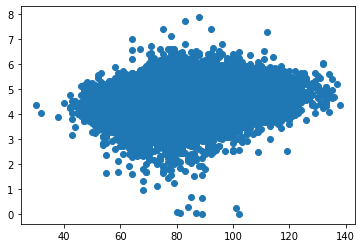

In [7]:
# Example 1: A graph showing diastolic blood preasure vs. red blood cell count
fig, ax = plt.subplots()
ax.scatter(additional_fields['diastolic_blood_preasure'], additional_fields['red_blood_cell_count'])

[Text(0, 0, 'F'), Text(0, 0, 'M')]

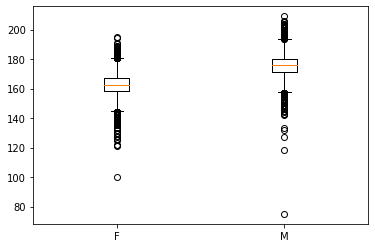

In [8]:
# Example 2: A graph showing height distribution per sex
fig, ax = plt.subplots()
ax.boxplot([additional_fields.loc[covariates['sex'] == 0, 'height'].dropna(), \
        additional_fields.loc[covariates['sex'] == 1, 'height'].dropna()])
ax.set_xticklabels(['F', 'M'])

# Working with genetic data

## Raw markers (BED files)

In [9]:
# Load the genetic data for chr17.
bim, fam, G = get_chrom_raw_marker_data('17')

# 'bim' is a dataframe containing information about the variants.
display(bim.head())
print('%d total variants.' % len(bim))

# 'fam' is a dataframe containing information about the samples (specifically, we need it to map the sample IDs).
assert (fam['i'] == np.arange(len(fam))).all()
summarize(fam)

# G is the genotyping matrix (see usage below).

[2019_12_29-14:09:45] /tmp/ukb_nadavb_chr17.bim: already exists.
[2019_12_29-14:09:45] /tmp/ukb_nadavb_chr17.bed: already exists.
[2019_12_29-14:09:45] /tmp/ukb_nadavb_chr17.fam: already exists.


Mapping files: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


,chrom,snp,cm,pos,a0,a1,i
0,17,rs2294076,0.0,6157,A,G,0
1,17,rs2396789,0.0,8547,T,C,1
2,17,rs36068254,0.0,10583,A,G,2
3,17,rs6565705,0.0,13905,G,A,3
4,17,rs2294075,0.0,14008,G,C,4


28835 total variants.


,fid,iid,father,mother,gender,trait,i
0,1509492,5094518,0,0,2,NaN,0
1,2042242,4066735,0,0,1,NaN,1
2,3028220,2815615,0,0,1,NaN,2
3,5193350,2632837,0,0,2,NaN,3
4,4554111,2235304,0,0,2,NaN,4


Displaying 5 of 488377 records (shuffled).


In [10]:
# In order to query the genotypes corresponding to samples in the phenotypic dataset we've parsed, we create a series
# mapping each sample_index (i.e. the index shared by 'eid', 'additional_fields', 'covariates' etc.) to its correspondig 
# index within the G matrix. This is done by creating a series mapping between the 'iid' (= eid) to the 'i' columns in the
# 'fam' dataframe. Note that the column 'i' provides the index within G of each sample.
genotyping_index = eid.map(fam.astype({'iid': int}).set_index('iid')['i'])
summarize(genotyping_index)

0    128379
1    234670
2    202806
3    344574
4     64808
Name: eid, dtype: int64

Displaying 5 of 274833 records (shuffled).


In [11]:
import statsmodels.api as sm

# As a simple example, we will run association tests for each of the the variants in the gonomic locus
# chr17:59,500,000-59,520,000 against the height phenotype.
relevant_variants = bim[bim['pos'].between(59500000, 59520000)].copy()

pval_results = []

for i, (_, variant) in enumerate(relevant_variants.iterrows()):
    
    print('Variant %d/%d' % (i + 1, len(relevant_variants)), end = '\r')
    
    # variant['i'] gives the index of the variant, so taking this row in the G matrix will give the genotypes of all the
    # UKBB samples for this variant. The values in the G matrix indicate the genotype of each individual for each variant.
    # These values can be 0 (homozygous reference, i.e. no copies of the alternative allele), 1 (heterozygous, i.e. one
    # copy of the alternative allele) or 2 (homozygous alternative, i.e. two copies of the alternative allele).
    variant_genotypes = G[variant['i'], :].compute()
    # We use the genotyping_index to retrieve only the relevant samples from the loaded genotypes (and in the right order),
    # so we end up with a vector of genotypes aligned to our dataset.
    sample_variant_genotypes = variant_genotypes[genotyping_index.values]
    sample_variant_genotypes = pd.Series(sample_variant_genotypes, index = eid.index).rename('genotype')
    
    # We construct the relevant dataset for this variant. The exogenous variables (X) will be all the covariates, along
    # with the genotypes (the variable we are really interested in) and the endogenous variable (y) will be the height.
    mask = pd.notnull(sample_variant_genotypes) & pd.notnull(additional_fields['height'])
    y = additional_fields.loc[mask, 'height']
    X = pd.concat([covariates, sample_variant_genotypes], axis = 1).loc[mask]
    
    # We train a simple linear-regression model (OLS) to calculate a p-value for this variant's genotypes (as a variable
    # in the OLS, after accounting for all other covariates).
    model = sm.OLS(y, X)
    variant_results = model.fit()
    pval = variant_results.pvalues['genotype']
    pval_results.append(pval)

# We finalize and display the results (the p-value derived for any of the variants).
relevant_variants['height_pval'] = pval_results
display(relevant_variants)

,chrom,snp,cm,pos,a0,a1,i,height_pval
20242,17,rs4968433,0.0,59500333,G,A,20242,1.120956e-15
20243,17,rs878745,0.0,59502319,T,C,20243,1.170154e-22
20244,17,rs9896616,0.0,59516472,T,C,20244,3.063647e-09
20245,17,rs62071328,0.0,59517034,T,C,20245,1.196334e-01
20246,17,rs146944614,0.0,59518015,G,A,20246,2.971785e-02


## Imputation genetic data (BGEN files)

In [12]:
# We load the imputation data for chr16.
chrom_imputation_reader = get_chrom_imputation_data('16')

# All the imputed variants on the chromosome can be accessed through this dataframe. 
display(chrom_imputation_reader.variants.head())

print('%d total variants.' % chrom_imputation_reader.n_variants)
print('%d samples with imputed variants on this chromosome.' % chrom_imputation_reader.n_samples)

# Provides the eid corresponding to each sample in the imputation reader.
summarize(chrom_imputation_reader.sample_ids)

,chromosome,position,rsid,number_of_alleles,allele1,allele2,file_start_position,size_in_bytes
0,16,60086,rs537499872,2,G,C,15609040,52348
1,16,60105,rs556230663,2,G,C,15661388,7586
2,16,60112,rs575737384,2,G,A,15668974,5894
3,16,60164,rs181534180,2,G,T,15674868,110212
4,16,60169,rs558005370,2,G,A,15785080,12271


3089612 total variants.
487409 samples with imputed variants on this chromosome.


0    3314279
1    4761525
2    3651490
3    1747469
4    5360208
Name: eid, dtype: int64

Displaying 5 of 487409 records (shuffled).


In [13]:
# In order to query the imputed genotypes corresponding to samples in the phenotypic dataset we've parsed, we create a
# series mapping each sample_index (i.e. the index shared by 'eid', 'additional_fields', 'covariates' etc.) to its
# correspondig index within chrom_imputation_reader. This is done by creating a series mapping between the 'sample_ids'
# (= eid) to the index.
imputation_index = eid.map(chrom_imputation_reader.sample_ids.reset_index().set_index('eid')['index'])
imputation_mask = pd.notnull(imputation_index)
print('%d of the %d dataset samples have imputated variants on this chromosome.' % (imputation_mask.sum(), \
        len(imputation_mask)))
imputation_index = imputation_index[imputation_mask].astype(int)
summarize(imputation_index)

274224 of the 274833 dataset samples have imputated variants on this chromosome.


0    446523
1    191227
2    215707
3    477158
4    310393
Name: eid, dtype: int64

Displaying 5 of 274224 records (shuffled).


In [14]:
from scipy.stats import fisher_exact

'''
As a simple example, we consider the association between the variant rs9930506 in the FTO gene on chr16 to obesity (ICD-10
code E66). According to SNPedia, there should be an association between them (https://www.snpedia.com/index.php/Rs9930506).
'''

# We query the record of the variant we look for (given by rsid).
(_, variant_record), = chrom_imputation_reader.variants[chrom_imputation_reader.variants['rsid'] == 'rs9930506'].iterrows()
display(variant_record)

# We read the genotyping for the variant by providing the variant index (which is the name of the relevant row in the
# chrom_imputation_reader.variants dataframe).
variant_genotyping_probs = chrom_imputation_reader.read_variant_probs(variant_record.name)
# We use imputation_index to retrieve only the relevant samples from the loaded genotypes (and in the right order),
# so we end up with a vector of genotypes aligned to our dataset.
sample_variant_genotyping_probs = variant_genotyping_probs[imputation_index.values, :]
# The variant's genotyping is given as an Nx3 matrix, where N is the number of samples. Each row in the matrix
# represents the genotyping of a specific individual. Since imputation is probabalistic, the genotyping is described as
# three probabilities for having 0, 1 or 2 copies of the alternative allele, respectively (these are the same options
# for the raw markers in the BED files, as described above).
# For our purpose, we define a sample to be a carrier of the variant if there's at least 50% chance of it having any copy
# of the alternative allele (under an assumed dominant effect), i.e. if the probability for 0 copies is smaller than 0.5.
carrier_mask = (sample_variant_genotyping_probs[:, 0] <= 0.5)
print('There are %d carriers of the variant.' % carrier_mask.sum())

# We extract the node with ICD-10 coding E66, which stands for obesity.
(_, ICD10_node), = ICD10_tree[ICD10_tree['coding'] == 'E66'].iterrows()
# We create a mask vector, aligned to the samples used in imputation data, that would determine whether each sample is
# inflicted with obesity.
case_mask = pd.Series([(sample_index in ICD10_node['samples']) for sample_index in imputation_index.index], index = \
        imputation_index.index)
control_mask = ~case_mask
print('%d cases, %d controls.' % (case_mask.sum(), control_mask.sum()))

# We construct a contingency table counting the number of sample with each combination of being either a carrier or
# non-carrier of the allele, and being either of the case or the control group.
contingency_table = pd.DataFrame([
    [(carrier_mask & case_mask).sum(), (carrier_mask & control_mask).sum()],
    [((~carrier_mask) & case_mask).sum(), ((~carrier_mask) & control_mask).sum()],
], index = ['carriers', 'non_carriers'], columns = ['cases', 'controls'])
display(contingency_table)

# We run Fisher's exact test to test the reported association.
print('Fisher\'s exact test results: OR = %.2f, p-value = %.2g' % fisher_exact(contingency_table))

chromosome                      16
position                  53830465
rsid                     rs9930506
number_of_alleles                2
allele1                          A
allele2                          G
file_start_position    43160279967
size_in_bytes               135527
Name: 1583331, dtype: object

There are 186261 carriers of the variant.
12415 cases, 261809 controls.


,cases,controls
carriers,8817,177444
non_carriers,3598,84365


Fisher's exact test results: OR = 1.17, p-value = 2.6e-14


## Tip:

It is recommended to subscribe to the UKB-GENETICS@JISCMAIL.AC.UK mailing list (https://www.jiscmail.ac.uk/cgi-bin/webadmin?A0=UKB-GENETICS), where you can see the questions, answers and discussion of other researchers working with the UKBB genetic data, and also post your own questions regarding the dataset.